# Priors

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
import importlib
import os
import sys
sys.path.append('../../..')
#print(os.listdir("../../.."))

import utils.gmm
import utils.metrics
import utils.gmm_init
importlib.reload(utils.gmm)
importlib.reload(utils.metrics)
importlib.reload(utils.gmm_init)
from utils.gmm import GaussianMixture
from utils.gmm_init import GMMInitializer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Set random seeds for reproducibility
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)

Using device: cuda


In [2]:
n_features = 2
n_components = 4
max_iter = 1000

n_samples_1 = 1000
n_samples_2 = 500
n_samples_3 = 200
n_samples_4 = 300

center_1 = np.array([0, 0])
center_2 = np.array([-4, 4])
center_3 = np.array([4, -4])
center_4 = np.array([4, 4])

C = np.array([[0.0, -0.5], [1.5, 0.5]])
C_2 = np.array([[0.0, 0.2], [0.4, 1.7]])

component_1 = np.dot(np.random.randn(n_samples_1, 2), C) + center_1
component_2 = 0.7 * np.random.randn(n_samples_2, 2) + center_2
component_3 = 0.5 * np.random.randn(n_samples_3, 2) + center_3
component_4 = np.dot(np.random.randn(n_samples_4, 2), C_2) + center_4

X = np.concatenate([component_1, component_2, component_3, component_4], axis=0)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)


In [3]:
def plot_gmm_ellipses(gmm, X, ax=None, title='', color='blue', alpha=1.0):
    """
    Plot a scatter of all data points and overlay ellipses for each component
    in the GMM, along with the component means.
    """
    if ax is None:
        ax = plt.gca()

    ax.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c='black', s=2, alpha=0.3, label='Data')

    for k in range(gmm.n_components):
        mean_k = gmm.means_[k].detach().cpu().numpy()
        
        # Extract appropriate covariance
        if gmm.covariance_type == 'full':
            cov_k = gmm.covariances_[k].detach().cpu().numpy()
        elif gmm.covariance_type == 'diag':
            cov_k = np.diag(gmm.covariances_[k].detach().cpu().numpy())
        elif gmm.covariance_type == 'spherical':
            var = gmm.covariances_[k].detach().cpu().item()
            cov_k = np.eye(gmm.n_features) * var
        elif gmm.covariance_type == 'tied_full':
            cov_k = gmm.covariances_.detach().cpu().numpy()  # one shared covariance
        elif gmm.covariance_type == 'tied_diag':
            diag_vals = gmm.covariances_.detach().cpu().numpy()
            cov_k = np.diag(diag_vals)
        elif gmm.covariance_type == 'tied_spherical':
            var = gmm.covariances_.detach().cpu().item()
            cov_k = np.eye(gmm.n_features) * var
        else:
            raise ValueError("Unsupported covariance type.")
        
        # Decompose covariance to plot ellipse
        eigvals, eigvecs = np.linalg.eigh(cov_k)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

        # For example, 2 std dev => coverage ~95%
        std_dev = 2
        width, height = 2 * std_dev * np.sqrt(eigvals)
        ellipse = Ellipse(
            mean_k, width, height, angle=angle,
            edgecolor=color, facecolor='none', linewidth=2, alpha=alpha
        )
        ax.add_patch(ellipse)

        # Mark the mean
        ax.plot(mean_k[0], mean_k[1], 'o', color=color, markeredgecolor='black')

    ax.set_title(title)
    ax.axis('equal')
    ax.legend()


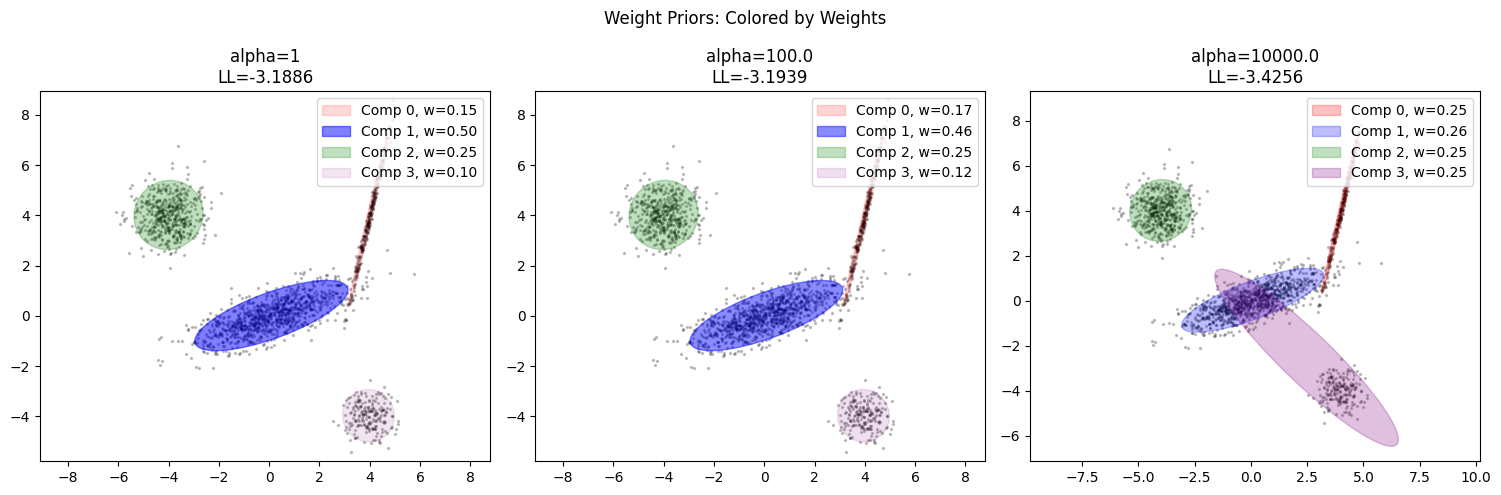

In [4]:
weight_concentration_values = [
    torch.tensor([1, 1, 1, 1], device=device),
    torch.tensor([100.0, 100.0, 100.0, 100.0], device=device),
    torch.tensor([10000.0, 10000.0, 10000.0, 10000.0], device=device)
]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Weight Priors: Colored by Weights")

colors = ['red', 'blue', 'green', 'purple']

for ax, alpha_vec in zip(axs, weight_concentration_values):
    gmm_weight_prior = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=1000,
        device=device,
        weight_concentration_prior=alpha_vec,
        random_state=random_state
    )
    gmm_weight_prior.fit(X_tensor)

    # Plot
    ax.scatter(X[:, 0], X[:, 1], c='black', s=2, alpha=0.2)
    for i, base_color in enumerate(colors):
        w_i = float(gmm_weight_prior.weights_[i].cpu().item())
        # Retrieve mean, covariance
        mean_i = gmm_weight_prior.means_[i].cpu().numpy()
        cov_i = gmm_weight_prior.covariances_[i].cpu().numpy()

        eigvals, eigvecs = np.linalg.eigh(cov_i)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        width, height = 2.0 * 2.0 * np.sqrt(eigvals)  # e.g. 2 std dev

        ell = Ellipse(mean_i, width, height, angle=angle,
                      edgecolor=base_color, facecolor=base_color,
                      alpha=w_i, label=f'Comp {i}, w={w_i:.2f}')
        ax.add_patch(ell)

    # Label each subplot with prior strength and final LL
    ax.set_title(f"alpha={alpha_vec[0].item()}\nLL={gmm_weight_prior.lower_bound_:.4f}")
    ax.axis('equal')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


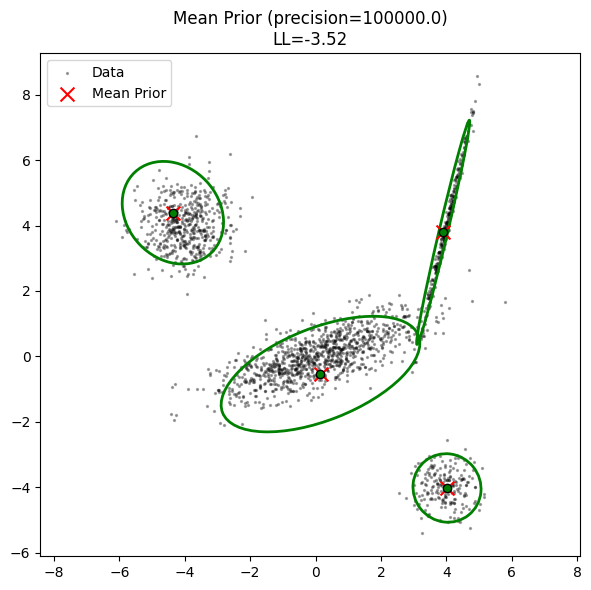

In [5]:
init_means_kmeans = GMMInitializer.kmeans(X_tensor.cpu(), k=n_components)  # do on CPU
mean_prior = init_means_kmeans.clone().to(device)
mean_precision_prior = 1e5  # large => strong push toward prior means

# perturb the prior means slightly
mean_prior += 0.5 * torch.randn_like(mean_prior)

gmm_mean_prior = GaussianMixture(
    n_features=n_features,
    n_components=n_components,
    covariance_type='full',
    max_iter=max_iter,
    device=device,
    mean_prior=mean_prior,
    mean_precision_prior=mean_precision_prior,
    random_state=random_state
)
gmm_mean_prior.fit(X_tensor)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
title = f"Mean Prior (precision={mean_precision_prior})\nLL={gmm_mean_prior.lower_bound_:.2f}"
plot_gmm_ellipses(gmm_mean_prior, X_tensor, ax=ax, title=title, color='green')

# Plot the prior means as red crosses
ax.scatter(mean_prior[:, 0].cpu(), mean_prior[:, 1].cpu(), marker='x', s=100, c='red', label='Mean Prior')
ax.legend()
plt.tight_layout()
plt.show()


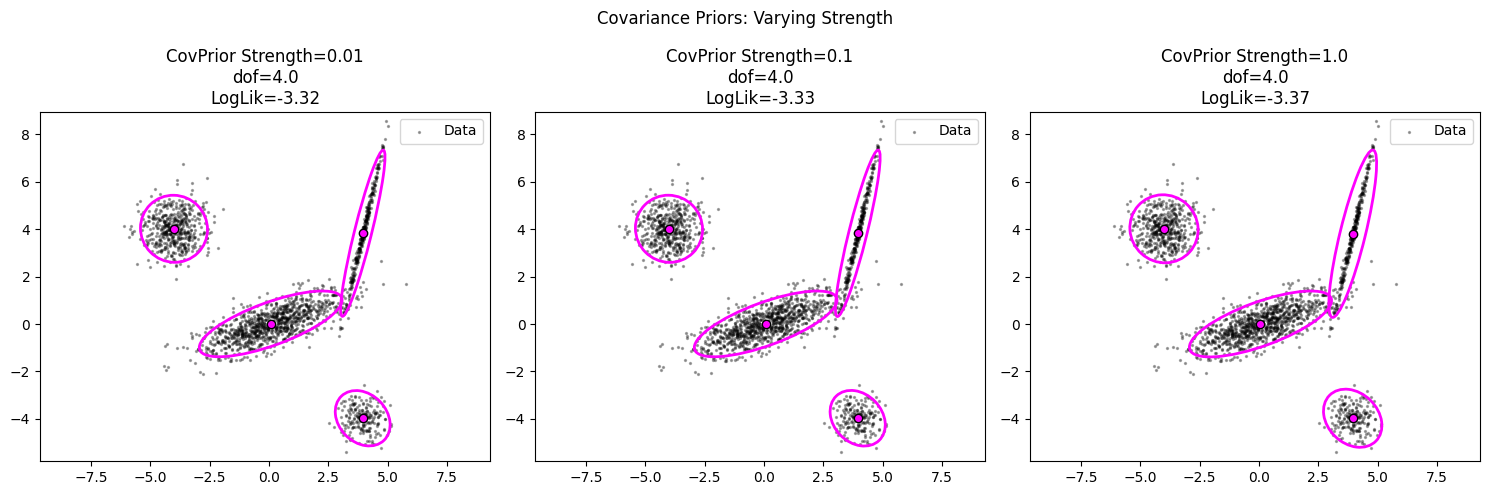

In [6]:
data_covariance = np.cov(X_tensor.cpu().numpy(), rowvar=False)  # shape (2, 2)
data_covariance = torch.tensor(data_covariance, dtype=torch.float32, device=device)
data_covariance = data_covariance.unsqueeze(0).expand(n_components, -1, -1)

degrees_of_freedom_prior = float(n_features + 2)
prior_strengths = [0.01, 0.1, 1.0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Covariance Priors: Varying Strength")

for ax, strength in zip(axs, prior_strengths):
    cov_prior = data_covariance * strength

    dummy_mean_prior = torch.zeros(n_components, n_features, device=device)
    dummy_mean_precision_prior = 1e-10  # effectively no strong push on means

    gmm_cov_prior = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=max_iter,
        device=device,
        # Covariance prior:
        covariance_prior=cov_prior,  
        degrees_of_freedom_prior=degrees_of_freedom_prior,
        # Provide "dummy" mean priors so code doesn't crash
        mean_prior=dummy_mean_prior,
        mean_precision_prior=dummy_mean_precision_prior
    )
    gmm_cov_prior.fit(X_tensor)


    title = (f"CovPrior Strength={strength}\n"
             f"dof={degrees_of_freedom_prior}\nLogLik={gmm_cov_prior.lower_bound_:.2f}")
    plot_gmm_ellipses(gmm_cov_prior, X_tensor, ax=ax, title=title, color='magenta')

plt.tight_layout()
plt.show()

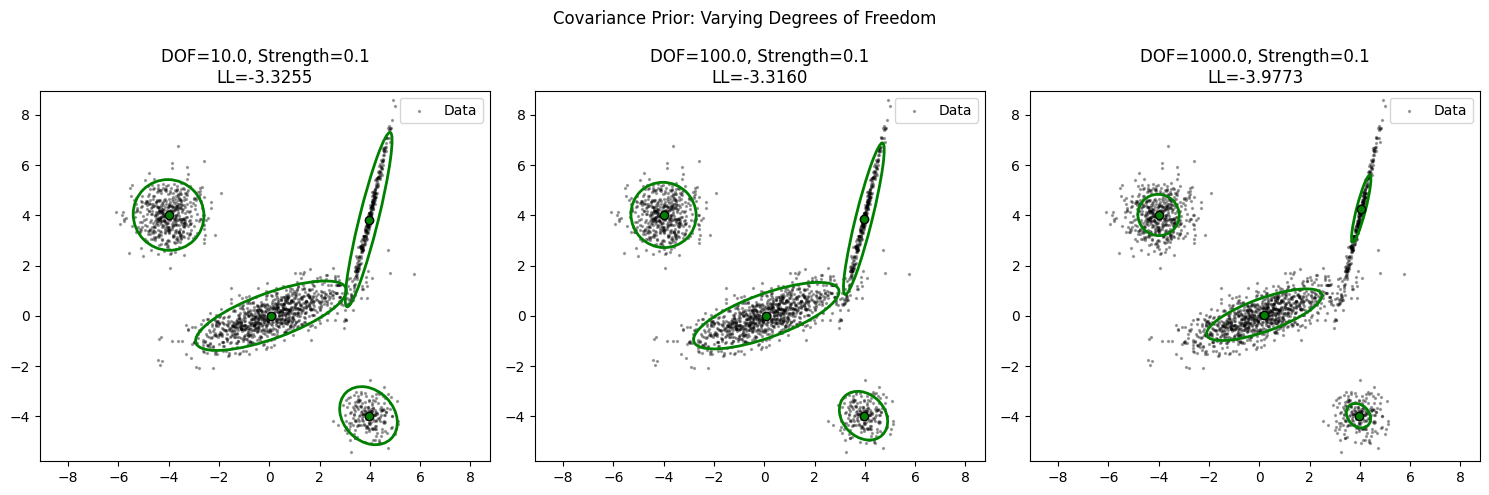

In [7]:
dof_values = [10.0, 100.0, 1000.0]  # must be > n_features - 1 => > 1 for 2D
strength = 0.1  # fixed prior strength for demonstration

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Covariance Prior: Varying Degrees of Freedom")

for ax, dof in zip(axs, dof_values):
    cov_prior = data_covariance * strength

    # Example to skip MAP on means by making them "neutral"
    dummy_mean_prior = torch.zeros(n_components, n_features, device=device)
    dummy_mean_precision_prior = 1e-10  # effectively no strong push on means

    gmm_cov_prior = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=max_iter,
        device=device,
        # Covariance prior:
        covariance_prior=cov_prior,  
        degrees_of_freedom_prior=dof,
        # Provide "dummy" mean priors so code doesn't crash
        mean_prior=dummy_mean_prior,
        mean_precision_prior=dummy_mean_precision_prior,
        random_state=random_state
    )
    gmm_cov_prior.fit(X_tensor)


    title = (f"DOF={dof}, Strength={strength}\n"
             f"LL={gmm_cov_prior.lower_bound_:.4f}")
    plot_gmm_ellipses(gmm_cov_prior, X_tensor, ax=ax, title=title, color='green')

plt.tight_layout()
plt.show()